In [1]:
cwk_dir ="drive/MyDrive/NLU Coursework/" #For running in Jack's Google Drive

# Setup

## Connect Google Drive Folder

In [2]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


## Imports

In [3]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate, BatchNormalization, SimpleRNN, Attention, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D, TimeDistributed
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import keras

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import typing
from PIL import Image
import json
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string
from random import randint

In [5]:
from transformers import BertTokenizer, BertModel

In [6]:
#Imports from local libraries
sys.path.append(cwk_dir)
from classes.evaluation import evaluate
from classes.preprocessing import load_data

## Primary Variables

Filepath variables

In [7]:
solution_dir = os.path.join(cwk_dir, "solution_B")
models_dir = os.path.join(solution_dir, "models")
results_dir = os.path.join(solution_dir, "results")

Preprocessing variables

In [20]:
LOWER: bool = True
PADDING: str = "post"

nltk.download('stopwords')
# STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training variables

In [9]:
INITIAL_LR: float = 2e-5
EPOCHS: int = 20
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 256

DROPOUT: float = 0.25

OPTIMIZER = RMSprop(INITIAL_LR)

Other

In [54]:
MAX_PREMISE_LENGTH: int = None
MAX_HYPOTHESIS_LENGTH: int = None

VOCAB_SIZE: int = None #None is the value to denote that there is no vocab size yet. This is set later, once we have the training data
EMBEDDING_SIZE: int = None

## Functions

In [56]:
def average_sequence_length(sequence: typing.List[str]) -> int:
  """
  Takes a list of sentences & returns the average length of sentences in that sequence
  """
  lengths = [len(sample) for sample in sequence]
  return int(np.sum(lengths)/len(lengths)) + 1

In [11]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  model.summary()
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [65]:
def tokenize_data(tokenizer: BertTokenizer, premises: typing.List[str], hypotheses: typing.List[str]) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = [tokenizer.encode(premise, add_special_tokens=True) for premise in premises]
  hypotheses = [tokenizer.encode(hypothesis, add_special_tokens=True) for hypothesis in hypotheses]

  premises = pad_sequences(premises, maxlen=MAX_PREMISE_LENGTH, padding=PADDING, value=0)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_HYPOTHESIS_LENGTH, padding=PADDING, value=0)

  return (np.array(premises), np.array(hypotheses))

In [13]:
def save_keras_model(model: Model, filename: str) -> None:
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(models_dir, f"{filename}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(models_dir, f"{filename}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [14]:
def clean_sentences(sentences: typing.List[str]) -> typing.List[str]:
  """
  Takes a list of sentences & cleans them. Remove stopwords, reduces to lower case, removes punctuation
  """
  sentences = [[word.lower().translate(str.maketrans("","",string.punctuation)) for word in sentence.split(" ") if word not in STOP_WORDS] for sentence in sentences]
  sentences = np.array([" ".join(sentence) for sentence in sentences])
  return sentences


In [15]:
def plot_history(history, export_path, legend: typing.List[str] = ['train', 'test']):
  """
  Will plot the history of a model, labelling it appropriately
  """
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


# Data Preprocessing

## Load Data

In [58]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [60]:
MAX_PREMISE_LENGTH: int = average_sequence_length(sequence=train_premises)
MAX_HYPOTHESIS_LENGTH: int = average_sequence_length(sequence=train_hypotheses)

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [61]:
train_labels = np.array(train_labels).reshape(len(train_labels),1)
dev_labels = np.array(dev_labels).reshape(len(dev_labels),1)

In [63]:
#Removes stop words, punctuation, reduces to lower case
train_premises = clean_sentences(sentences=train_premises)
train_hypotheses = clean_sentences(sentences=train_hypotheses)

dev_premises = clean_sentences(sentences=dev_premises)
dev_hypotheses = clean_sentences(sentences=dev_hypotheses)

### Example

In [64]:
index = randint(0, len(train_premises))
print(f"Premise: {train_premises[index]}")
print(f"Hypothesis: {train_hypotheses[index]}")
print(f"Label: {train_labels[index]}")

Premise: mr inglethorp said the coroner you have heard your wifes dying words repeated here 
Hypothesis: mr inglethorp as per your request your wifes dying words have been read
Label: [1]


## Tokenize Data

In [66]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

In [67]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(train_premises), hypotheses=list(train_hypotheses))
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(dev_premises), hypotheses=list(dev_hypotheses))

In [68]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 30522


### Example

In [69]:
#Premise
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_premises[index])}")
print(f"Tokens: {train_premises[index]}")

Sentence: ['[CLS]', 'mr', 'ing', '##let', '##hor', '##p', 'said', 'the', 'coroner', 'you', 'have', 'heard', 'your', 'wife', '##s', 'dying', 'words', 'repeated', 'here', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Tokens: [  1

In [70]:
#Hypothesis
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_hypotheses[index])}")
print(f"Tokens: {train_hypotheses[index]}")

Sentence: ['[CLS]', 'mr', 'ing', '##let', '##hor', '##p', 'as', 'per', 'your', 'request', 'your', 'wife', '##s', 'dying', 'words', 'have', 'been', 'read', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Tokens: [  101  2720 13749  7485 16368  2361  2004  2566  2115  5227  2115  2564
  2015  5996  2616  2031  2042  3191   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


## Embedding Matrix

In [71]:
embedding_matrix = bert_model.embeddings.word_embeddings.weight.detach().numpy()

In [72]:
if(EMBEDDING_SIZE is None):
  EMBEDDING_SIZE = np.shape(embedding_matrix)[1]
print(f"Embedding size: {EMBEDDING_SIZE}")

Embedding size: 768


# Model Training

## Learning Rate

In [ ]:
# decay_steps = int((len(train_premises)//BATCH_SIZE) * (1-VALIDATION_SPLIT)) + 1

# lr_schedule = ExponentialDecay(
#     INITIAL_LR,
#     decay_steps=decay_steps,
#     decay_rate=0.99,
#     staircase=True)

# OPTIMIZER = Adam(learning_rate=lr_schedule)

## Model Architecture

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_15 (Embedding)    multiple                     2344089   ['input_19[0][0]',            
                                                          6          'input_20[0][0]']            
                                                                                                  
 bidirectional_15 (Bidirect  (None, 1024)                 5246976   ['embedding_15[0][0]',  

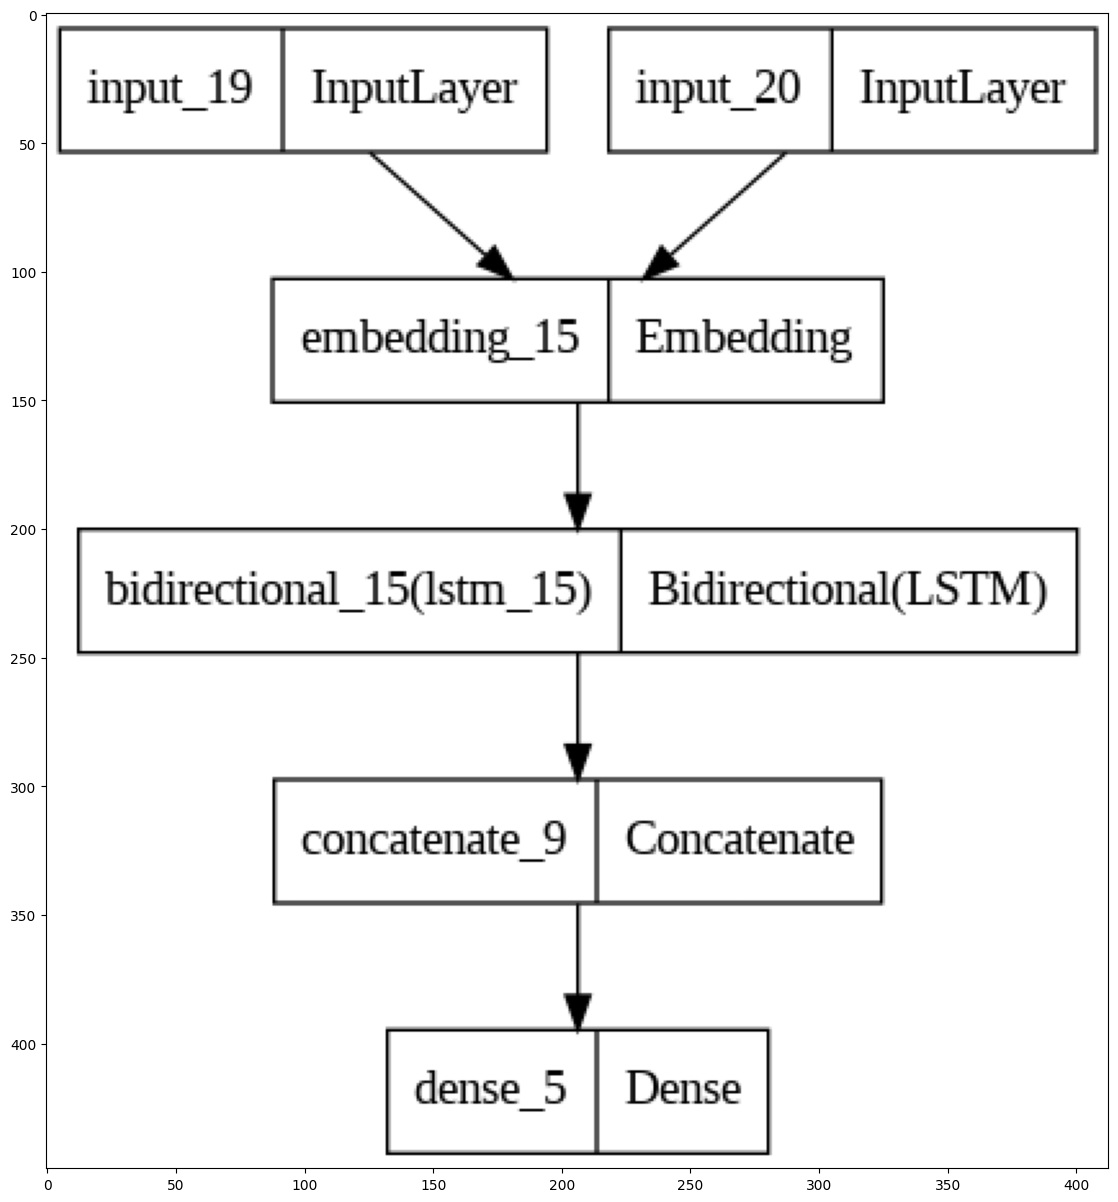

In [83]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

merged = concatenate([premises, hypotheses], axis=-1)

output_layer = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename="architecture_bert_embed.png")

## Model Training

In [84]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/20
85/85 [==============================] - 30s 243ms/step - loss: 0.6902 - accuracy: 0.5347 - val_loss: 0.6867 - val_accuracy: 0.5257
Epoch 2/20
85/85 [==============================] - 16s 184ms/step - loss: 0.6801 - accuracy: 0.5680 - val_loss: 0.6766 - val_accuracy: 0.5689
Epoch 3/20
85/85 [==============================] - 16s 183ms/step - loss: 0.6745 - accuracy: 0.5745 - val_loss: 0.6741 - val_accuracy: 0.5680
Epoch 4/20
85/85 [==============================] - 16s 189ms/step - loss: 0.6727 - accuracy: 0.5775 - val_loss: 0.6720 - val_accuracy: 0.5704
Epoch 5/20
85/85 [==============================] - 15s 181ms/step - loss: 0.6708 - accuracy: 0.5825 - val_loss: 0.6713 - val_accuracy: 0.5728
Epoch 6/20
85/85 [==============================] - 16s 183ms/step - loss: 0.6697 - accuracy: 0.5839 - val_loss: 0.6696 - val_accuracy: 0.5790
Epoch 7/20
85/85 [==============================] - 15s 181ms/step - loss: 0.6680 - accuracy: 0.5856 - val_loss: 0.6679 - val_accuracy: 0.5799

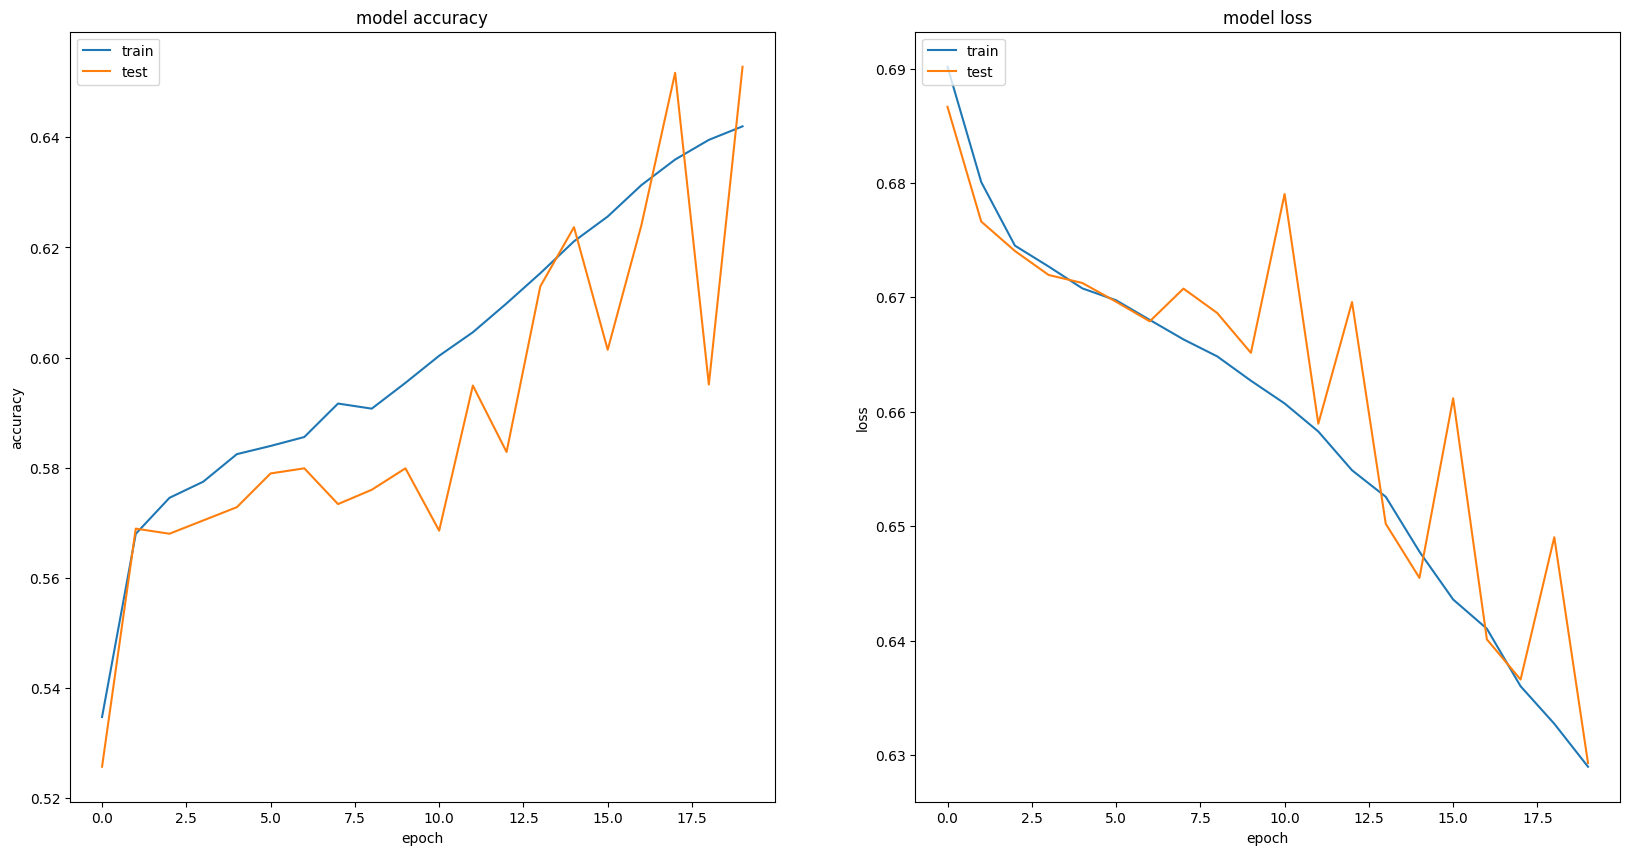

In [85]:
plot_history(history=history, export_path="model_bert_embed.pdf")

In [86]:
#Save the model
save_keras_model(model=model, filename="model_bert_embed")

## Model Evaluation

In [87]:
#Get loss
loss, _ = model.evaluate([dev_premises, dev_hypotheses], dev_labels)
print("\nTest score/loss:", loss)

211/211 [==============================] - 4s 18ms/step - loss: 0.6297 - accuracy: 0.6533

Test score/loss: 0.6296650171279907


In [88]:
predicted_labels = model.predict(x=[dev_premises, dev_hypotheses])
predicted_labels = (predicted_labels > 0.5).astype(int)

#Evaluation Metrics
test_metrics = evaluate(true_labels=np.array(dev_labels), predicted_labels=np.array(predicted_labels))
test_metrics.to_csv(os.path.join(results_dir, "metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 4s 15ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC
0,0.653258,0.638929,0.657303,0.656705,0.755032,0.649839,0.653258,0.692145,0.647636,0.649083,0.30705
